# Social Distancing and Ad Campaigns on Covid-19

Importing the data

In [ ]:
from google.colab import drive
#Just login, follow the link and copy the code
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
file = np.load('/content/drive/My Drive/PSTAT_197A/part2.npz')

In [ ]:
beta_old=file['beta_old']
N=file['N']
Svc_0_PMF=file['Svc_0_PMF']
Lc=file['Lc']
Ic_0=file['Ic_0']
gamma=file['gamma']
L_observed=file['L_observed']
nb_nodes = Svc_0_PMF.shape[0]



## Assuming people start social distancing on day 10, how would the spread change?

### Determining different populations' rate of spread after social distancing

In [ ]:
def SIR(t, Z, N, betas, gamma):
    (S_vec, I_vec, R) = (Z[:16].reshape(4, 4), Z[16:20], Z[-1])
    I = I_vec.sum()
    dSdt = -betas*S_vec*I/N 
    dIdt = -dSdt.sum(axis=0)-gamma*I_vec
    dRdt = np.array([gamma*I])
    return np.concatenate((dSdt.flatten(), dIdt, dRdt))

In [ ]:
from scipy.integrate import solve_ivp
from scipy.optimize import fmin, fminbound
from sklearn.metrics import mean_squared_error

Svc_0_PMF /= Svc_0_PMF.sum(axis=(1, 2), keepdims=True)
Svc_0 = (N-Ic_0.sum(axis=1))[:, np.newaxis, np.newaxis]*Svc_0_PMF
Svc_0 = Svc_0.round().astype(int)
R0 = np.zeros((nb_nodes)).astype(int)

t = np.linspace(0, 199, 200)

S = np.zeros((nb_nodes, 4, 4, len(t)))
I = np.zeros((nb_nodes, 4, len(t)))
R = np.zeros((nb_nodes, len(t)))
L = np.zeros((nb_nodes, len(t)))

for N_node, node_index in zip(N, range(nb_nodes)):

    initial_conditions = np.concatenate(
        (Svc_0[node_index].flatten(), Ic_0[node_index], [R0[node_index]]))

    soln = solve_ivp(
        SIR, (t[0], t[9]), initial_conditions, args=(N_node, beta_old, gamma), t_eval=t[:10])

    S[node_index, :, :, :10] = soln.y[:16].reshape(4, 4, -1)
    I[node_index, :, :10] = soln.y[16:20]
    R[node_index, :10] = soln.y[20]
    L[node_index, :10] = Lc@soln.y[16:20]


alpha_predicted = np.zeros((nb_nodes))

def loss_func(alpha):
    initial_conditions = np.concatenate(
       (S[node_index, :, :, 9].flatten(), I[node_index,:,9], [R[node_index,9]]))

    soln = solve_ivp(
        SIR, (t[9], t[30]), initial_conditions, 
        args=(N_node, alpha * beta_old, gamma), 
        t_eval=t[9:30])

    S[node_index, :, :, 9:30] = soln.y[:16].reshape(4, 4, -1)
    I[node_index, :, 9:30] = soln.y[16:20]
    R[node_index, 9:30] = soln.y[20]
    L[node_index, 9:30] = Lc@soln.y[16:20]

    return mean_squared_error(L_observed[node_index, 9:30], L[node_index, 9:30])

for N_node, node_index in zip(N, range(nb_nodes)):
    alpha_predicted[node_index] = fmin(loss_func, 0.5, disp=False)

def print_all_alphas():
  for i in range(nb_nodes):
    print("Alpha for node =", i+1, ":", alpha_predicted[i])

print_all_alphas()

Alpha for node = 1 : 0.23352203369140603
Alpha for node = 2 : 0.38600540161132807
Alpha for node = 3 : 0.22739257812499974
Alpha for node = 4 : 0.7097534179687506
Alpha for node = 5 : 0.6778823852539068
Alpha for node = 6 : 0.2068450927734372
Alpha for node = 7 : 0.35756835937499987
Alpha for node = 8 : 0.3565780639648436
Alpha for node = 9 : 0.3794677734374998
Alpha for node = 10 : 0.18710937499999972
Alpha for node = 11 : 0.2828369140624998
Alpha for node = 12 : 0.3296874999999998
Alpha for node = 13 : 0.3142089843749998
Alpha for node = 14 : 0.21623229980468728
Alpha for node = 15 : 0.13437347412109343
Alpha for node = 16 : 0.24157714843749975
Alpha for node = 17 : 0.20031738281249975
Alpha for node = 18 : 0.552960205078125
Alpha for node = 19 : 0.5807571411132815
Alpha for node = 20 : 0.1822143554687497
Alpha for node = 21 : 0.2694824218749998
Alpha for node = 22 : 0.30437316894531236
Alpha for node = 23 : 0.48615722656250004
Alpha for node = 24 : 0.3096679687499998
Alpha for node 

## Budgeting Ad Campaigns for Different Populations

How should one distribute $1,000,000 between 100 different populations? Trying different policies and comparing the results.  
**NPI** - *non-pharmeceutical interventions*, such as an ad campaign

In [ ]:
def g(money):
    alpha = 1/np.log2(2*10**(-3)*money+2)
    return alpha

def g_inv(alpha):
    money = (2**(1/alpha)-2)/(2*10**(-3))
    return money

import matplotlib.pyplot as plt 

def scatter_plot(alpha_afterNPI):
    plt.figure()
    colors=(beta_old[np.newaxis,:,:]*Svc_0_PMF).mean(axis=(1,2))
    plt.scatter(alpha_predicted, alpha_afterNPI, s=N/500, c=colors, 
                cmap='jet', alpha=0.5)
    plt.xlabel(r"$\alpha_{own}$")
    plt.ylabel(r"$\alpha_{after\ NPI}$")

def total_recovered_difference(alpha_afterNPI):
    
    # Note: 1*10**6 = 1,000,000 or 1 million
    difference = abs( 1*10**6 - sum(g_inv(alpha_predicted - alpha_afterNPI)) )
    
    # prevents the sum of alpha_afterNPI from rounding over $1 million
    difference = round(difference, 2)
    
    return difference

def graph_SIR(S_, I_, R_, L_, S_with, I_with, R_with, L_with):
    plt.figure(figsize=(14,5))
    
    plt.subplot(1,2,1)
    plt.plot( np.sum(S_, axis=(0,1,2)), label="Susceptible" )
    plt.plot( np.sum(I_, axis=(0,1)), label="Infected" )
    plt.plot( np.sum(R_, axis=(0)), label="Recovered" )
    plt.vlines(x=10, ymin=0, ymax=max(np.sum(S_, axis=(0,1,2))), color='pink', 
               linestyles='dashed', linewidth=3, label="NPI Starts")
    plt.scatter(x=range(0,20), y=np.sum(L_, axis=(0))[:20], 
                label="Viral Load", color="red")
    plt.xlabel("Day")
    plt.title('Group Population Total Without NPI')
    plt.ylabel("Count (Per 1 million)")
    plt.legend(loc=5, title="Legend")
    
    plt.subplot(1,2,2)
    plt.plot( np.sum(S_with, axis=(0,1,2)), label="Susceptible" )
    plt.plot( np.sum(I_with, axis=(0,1)), label="Infected" )
    plt.plot( np.sum(R_with, axis=(0)), label="Recovered" )
    plt.vlines(x=10, ymin=0, ymax=max(np.sum(S_, axis=(0,1,2))), color='pink', 
               linestyles='dashed', linewidth=3, label="NPI Starts")
    plt.scatter(x=range(0,20), y=np.sum(L_with, axis=(0))[:20], 
                label="Viral Load", color="red")
    plt.xlabel("Day")
    plt.title('Group Population Total With NPI')
    plt.ylabel("Count (Per 1 million)")
    plt.legend(loc=1, title="Legend")
    
    plt.show()

def SIR_noNPI():
    
    for N_node, node_index in zip(N, range(nb_nodes)):
        initial_conditions = np.concatenate(
            (Svc_0[node_index].flatten(), Ic_0[node_index], [R0[node_index]]))
        
        soln = solve_ivp(
            SIR, (t[0], t[199]), initial_conditions, 
            args=(N_node, beta_old, gamma), 
            t_eval=t[:])
        
        S[node_index, :, :, :] = soln.y[:16].reshape(4, 4, -1)
        I[node_index, :, :] = soln.y[16:20]
        R[node_index, :] = soln.y[20]
        L[node_index, :] = Lc@soln.y[16:20]
    
    return (S, I, R, L)

def SIR_withNPI(alpha_):
    
    S_withNPI = np.zeros(S.shape)
    I_withNPI = np.zeros(I.shape)
    R_withNPI = np.zeros(R.shape)
    L_withNPI = np.zeros(L.shape)
    
    for N_node, node_index in zip(N, range(nb_nodes)):
        initial_conditions = np.concatenate(
            (S[node_index,:,:,10].flatten(), 
             I[node_index,:,10], [R[node_index,10]]))
        
        soln = solve_ivp(
            SIR, (t[10], t[199]), initial_conditions, 
            args=(N_node, alpha_[node_index] * beta_old, gamma), 
            t_eval=t[10:])
        
        S_withNPI[node_index, :, :, :10] = S[node_index, :, :, :10]
        S_withNPI[node_index, :, :, 10:] = soln.y[:16].reshape(4, 4, -1)
        I_withNPI[node_index, :, :10] = I[node_index, :, :10]
        I_withNPI[node_index, :, 10:] = soln.y[16:20]
        R_withNPI[node_index, :10] = R[node_index, :10]
        R_withNPI[node_index, 10:] = soln.y[20]
        L_withNPI[node_index, :10] = L[node_index, :10]
        L_withNPI[node_index, 10:] = Lc@soln.y[16:20]
    
    return (S_withNPI, I_withNPI, R_withNPI, L_withNPI)

### Policy #1 

Same budget for each node

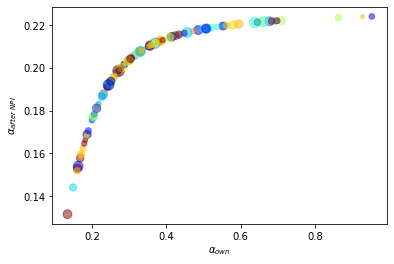

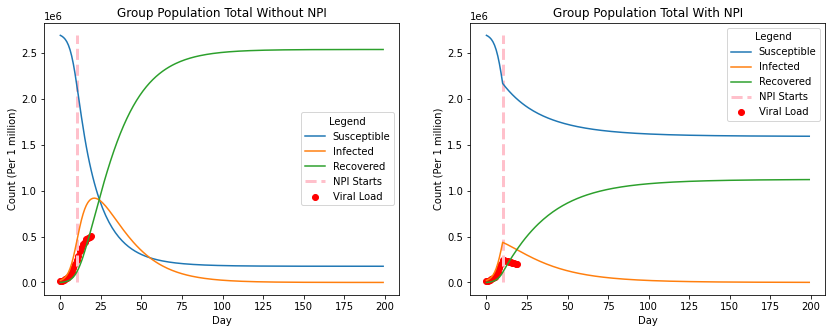

         With NPI, 1417281 less people recovered / succumbed.


In [ ]:
# Everyone gets a budget of $10,000
alpha_afterNPI= np.zeros((nb_nodes))
for i in range(nb_nodes):
    alpha_afterNPI[i]=g(g_inv(alpha_predicted[i])+10000)

scatter_plot(alpha_afterNPI)

#Plot SIR
S, I, R, L = SIR_noNPI()
S_withNPI, I_withNPI, R_withNPI, L_withNPI = SIR_withNPI(alpha_afterNPI)
graph_SIR(S, I, R, L, S_withNPI, I_withNPI, R_withNPI, L_withNPI)

#Part ii
R_difference = np.sum(R, axis=(0))[199] - np.sum(R_withNPI, axis=(0))[199]
print("         With NPI,", int(round(R_difference, 0)), 
      "more" if R_difference < 0 else "less", "people recovered / succumbed.")

With the allocation of NPI, 1,417,281 less people recovered/succumbed to Covid-19. This is seen by comparing the green line on the graph. The graph flattens at a much lower population.

### Policy #2

Budgeted proportional to each node's total population

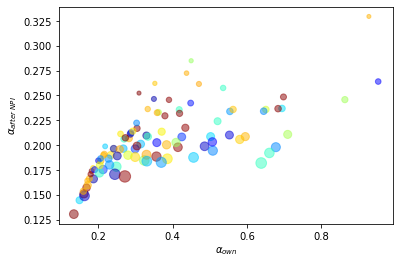

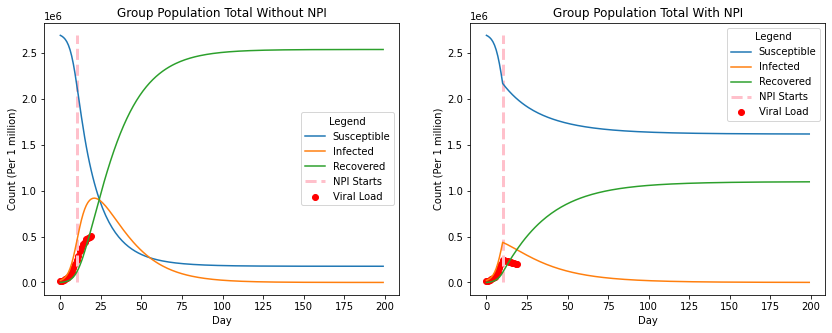

         With NPI, 1441583 less people recovered / succumbed.


In [ ]:
# Total population amongst all nodes
total_N = sum(N)
# Budget is spread based on percentage of total population
budget_per_N = N / total_N * 1*10**6
alpha_afterNPI2= np.zeros((nb_nodes))
for i in range(nb_nodes):
    alpha_afterNPI2[i]=g(g_inv(alpha_predicted[i])+budget_per_N[i])

scatter_plot(alpha_afterNPI2)

S, I, R, L = SIR_noNPI()
S_withNPI, I_withNPI, R_withNPI, L_withNPI = SIR_withNPI(alpha_afterNPI2)
graph_SIR(S, I, R, L, S_withNPI, I_withNPI, R_withNPI, L_withNPI)

# Part ii
R_difference = np.sum(R, axis=(0))[199] - np.sum(R_withNPI, axis=(0))[199]
print("         With NPI,", int(round(R_difference, 0)), 
      "more" if R_difference < 0 else "less", "people recovered / succumbed.")

With Policy 2's allocation of the budget, 1,441,583 less people recovered/succumbed. This is more than Policy 1.

### Policy #3

Budget so that the predicted rate of spread is decreased equally for each node

Smallest alpha_predicted = 0.13437347412109343
(Policy #3) Alpha Difference = 0.010337394714355472


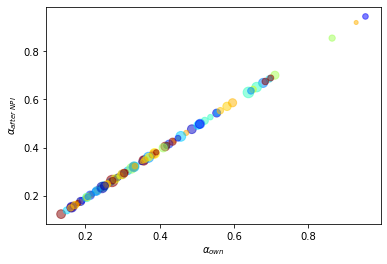

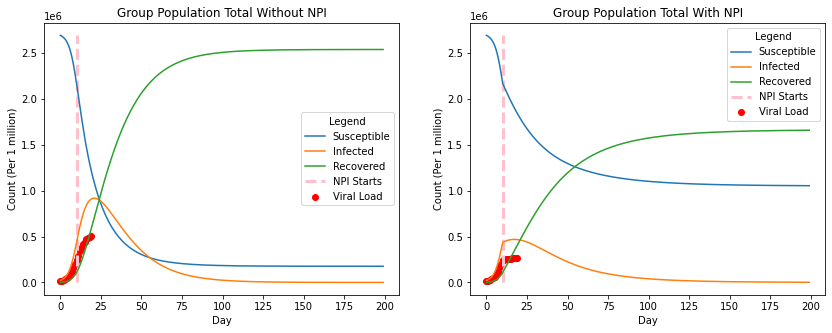

         With NPI, 879425 less people recovered / succumbed.


In [ ]:
# Policy #3 code
print("Smallest alpha_predicted =", min(alpha_predicted) )

# Make sure to start with an x0 guess less than the small alpha_predicted value
delta_alpha = fmin(total_recovered_difference, 0.0, disp=False)[0]
print("(Policy #3) Alpha Difference =", delta_alpha)

alpha_afterNPI = alpha_predicted - delta_alpha
scatter_plot(alpha_afterNPI)

S, I, R, L = SIR_noNPI()
S_withNPI, I_withNPI, R_withNPI, L_withNPI = SIR_withNPI(alpha_afterNPI)
graph_SIR(S, I, R, L, S_withNPI, I_withNPI, R_withNPI, L_withNPI)

# Part ii
R_difference = np.sum(R, axis=(0))[199] - np.sum(R_withNPI, axis=(0))[199]
print("         With NPI,", int(round(R_difference, 0)), 
      "more" if R_difference < 0 else "less", "people recovered / succumbed.")

With Policy #3's budget allocation, 879,425 less people recovered / succumed to the disease with NPI than without NPI.

### Policy #4

Budget based on viral load for each node

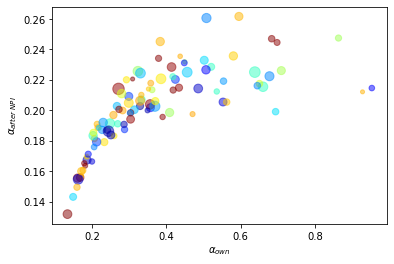

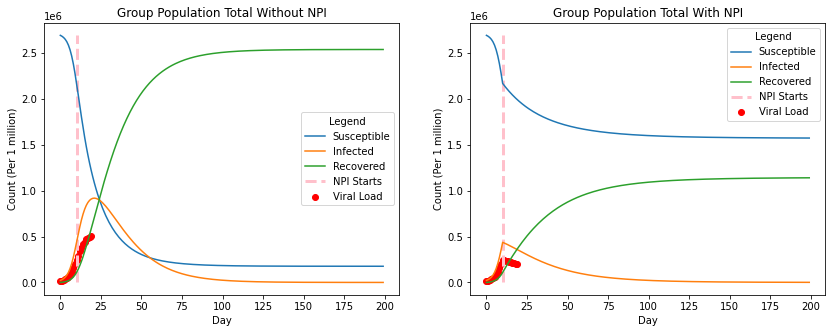

         With NPI, 1397850 less people recovered / succumbed.


In [ ]:
#Basing it off of observed viral load densities on day 1
total_L=sum(L_observed[:,0])
budget_per_node=L_observed[:,0]/total_L * 1*10**6
alpha_afterNPI4= np.zeros((nb_nodes))
for i in range(nb_nodes):
    alpha_afterNPI4[i]=g(g_inv(alpha_predicted[i])+budget_per_node[i])
    
scatter_plot(alpha_afterNPI4)

S, I, R, L = SIR_noNPI()
S_withNPI, I_withNPI, R_withNPI, L_withNPI = SIR_withNPI(alpha_afterNPI4)
graph_SIR(S, I, R, L, S_withNPI, I_withNPI, R_withNPI, L_withNPI)

# Part ii
R_difference = np.sum(R, axis=(0))[199] - np.sum(R_withNPI, axis=(0))[199]
print("         With NPI,", int(round(R_difference, 0)), 
      "more" if R_difference < 0 else "less", "people recovered / succumbed.")

With NPI, 1,397,850 less people recovered / succumbed comapred to the original population without NPI.

## Comparing the Policies

One way to measure the effectiveness of the 4 policies is to compare the change in the number of recovered individuals before and after money was spent on NPI.

In [ ]:
# If an element is > 1.0, then the bar will be green; otherwise it will be maroon.
def cmap_func(arr):
  color_arr = [None] * len(arr)
  for i in range(len(arr)):
    color_arr[i] = 'forestgreen' if arr[i] > 1.0 else 'maroon'
  
  return color_arr

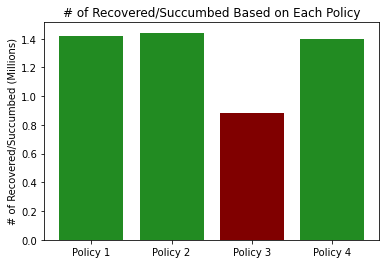

In [ ]:
# bar plot comparing the number of people recovered after each policy

recovered = [1417281/1000000, 1441583/1000000, 879425/1000000, 1397850/1000000]
bars = ['Policy 1', 'Policy 2', 'Policy 3', 'Policy 4']
y_pos = np.arange(len(bars))
plt.bar(y_pos,recovered,color=cmap_func(recovered))
plt.xticks(y_pos,bars)
plt.ylabel('# of Recovered/Succumbed (Millions)')
plt.title('# of Recovered/Succumbed Based on Each Policy')
plt.show()

By just comparing the number of recovered/succumbed after each policy was enacted, it's clear that policies 1, 2, and 4 have similar effectiveness, while policy 3 is less effective by a large degree. Thus, it would make sense to weigh the ethics and fairness of policies 1, 2, and 3 since they share similar effectiveness. 